In [1]:
import numpy as np
from glob import glob
#from bing_image_downloader import downloader
import json
from tqdm import tqdm
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.applications import vgg19
import matplotlib.pyplot as plt
from tensorflow.keras.applications import resnet
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


CROP = 256
target_shape = (CROP,CROP)
latent_dim = 256

2023-02-14 19:42:11.371001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 19:42:11.940241: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-14 19:42:11.940288: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64

# Adversarial neural style transfer

In [2]:
artist = [i.split('/')[-1] for i in glob('./dataset/artist/*')]

In [3]:
def open_frame(band,var=1,CROP = 256):
    

    pic = glob(f'./dataset/artist/{band}*/*')
    input_path = pic[np.random.choice(len(pic))]
    
    img = np.asarray(cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2RGB), dtype=np.float32)
    img = cv2.resize(img,(CROP,CROP))
    img = img - np.amin(img)
    input_channel = img/np.amax(img)
    input_channel += -1
    
    cover = glob(f'./dataset/spotify/{band}*/*')
    cover_path = cover[np.random.choice(len(cover))]
    cover_path2 = pic[np.random.choice(len(pic))]
    
    cover = np.asarray(cv2.cvtColor(cv2.imread(cover_path), cv2.COLOR_BGR2RGB), dtype=np.float32)
    cover = cv2.resize(cover,(CROP,CROP))
    cover = cover - np.amin(cover)
    cover_channel = cover/np.amax(cover)
    cover_channel += -1
    
    cover2 = np.asarray(cv2.cvtColor(cv2.imread(cover_path2), cv2.COLOR_BGR2RGB), dtype=np.float32)
    cover2 = cv2.resize(cover2,(CROP,CROP))
    cover2 = cover2 - np.amin(cover2)
    cover_channel2 = cover2/np.amax(cover2)
    cover_channel2 += -1
    
    
    return np.array([input_channel, cover_channel,cover_channel2])


In [4]:
def augment(yx, crop=256, do_flips=False, do_rotate=True, do_scale=False):
    
    if do_flips:
        if np.random.uniform(0,1) > 0.5:
            if np.random.uniform(0,1) > 0.5:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],0)
            else:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],1)
 
    if do_rotate:
        ch, cw = yx[0].shape[:2]
        
        for i in range(len(yx)):
            
            if i == 1:
                continue
            
            rotation_matrix = cv2.getRotationMatrix2D((cw/2,ch/2),np.random.randint(-45,45),1)
            yx[i] = cv2.warpAffine(yx[i],rotation_matrix, (ch,cw),cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    
    return yx

In [5]:
N_REPEAT_FRAME = 10

def sample_images(band):
    while True:
        try:
            img = open_frame(np.random.choice(band))
        except Exception as e:
            print(f'Exception {e} on file')
            #continue
            break
        for n in range(N_REPEAT_FRAME):
            img = open_frame(np.random.choice(band))
            a =  augment(img,crop = CROP)
            yield a

In [6]:
def get_data_generator(sampler):
    def get_data():
        while True:
            yx = next(sampler)
            
            x, y, z = yx[0], yx[1], yx[2]
            
            #yield x,y
            yield {"input_photo":x,"input_cover":z},y
    return get_data

In [7]:
BATCH_SIZE = 10

dg_train = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(artist[:int(1*len(artist))])),
    output_types=({"input_photo":tf.float32,"input_cover":tf.float32}, tf.float32),
    output_shapes=({"input_photo":(CROP, CROP, 3),"input_cover":(CROP, CROP, 3)}, (CROP, CROP, 3)) )

dg_val = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(artist[int(0.8*len(artist)):])),
    output_types=({"input_photo":tf.float32,"input_cover":tf.float32}, tf.float32),
    output_shapes=({"input_photo":(CROP, CROP, 3),"input_cover":(CROP, CROP, 3)}, (CROP, CROP, 3)) )

gen_batch_train = dg_train.batch(BATCH_SIZE)
gen_batch_val = dg_val.batch(BATCH_SIZE)

2023-02-14 19:42:12.890454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 19:42:12.890687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 19:42:12.919067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 19:42:12.919302: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 19:42:12.919477: I tensorflow/compiler/xla/stream_executo

In [8]:
xs, ys = next(gen_batch_train.as_numpy_iterator())

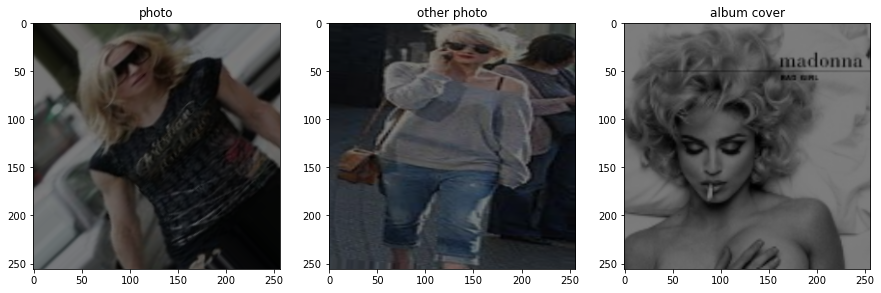

In [9]:
_ = np.random.choice(len(xs['input_photo']))
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow((xs['input_photo'][_]+1)/2)
plt.title('photo')
plt.subplot(132)
plt.imshow((xs['input_cover'][_]+1)/2)
plt.title('other photo')
plt.subplot(133)
plt.imshow((ys[_]+1)/2)
plt.title('album cover')

plt.show()

# Autoencoder

In [62]:
artist = [i.split('/')[-1] for i in glob('./dataset/artist/*')]

def augment(yx, crop=256, do_flips=True, do_rotate=True, do_scale=False):
    
    if do_flips:
        if np.random.uniform(0,1) > 0.5:
            if np.random.uniform(0,1) > 0.5:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],0)
            else:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],1)
 
    if do_rotate:
        ch, cw = yx[0].shape[:2]
        rotation_matrix = cv2.getRotationMatrix2D((cw/2,ch/2),np.random.randint(-90,90),1)
        for i in range(len(yx)):
            
            yx[i] = cv2.warpAffine(yx[i],rotation_matrix, (ch,cw),cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    
    return yx

def open_frame(band,var=1,CROP = 256):
    

    pic = glob(f'./dataset/artist/{band}*/*')
    input_path = pic[np.random.choice(len(pic))]
    
    img = np.asarray(cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2RGB), dtype=np.float32)
    img = cv2.resize(img,(CROP,CROP))
    img = img - np.amin(img)
    input_channel = img/np.amax(img)
    
    
    return np.array([input_channel, input_channel])

N_REPEAT_FRAME = 10

def sample_images(band):
    while True:
        try:
            img = open_frame(np.random.choice(band))
        except Exception as e:
            print(f'Exception {e} on file')
            #continue
            break
        for n in range(N_REPEAT_FRAME):
            img = open_frame(np.random.choice(band))
            a =  augment(img,crop = CROP)
            yield a
            
            
def get_data_generator(sampler):
    def get_data():
        while True:
            yx = next(sampler)
            
            x, y = yx[0], yx[1]
            
            yield x,y
    return get_data

In [35]:
BATCH_SIZE = 50

dg_train = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(artist[:int(0.8*len(artist))])),
    output_types=(tf.float32, tf.float32),
    output_shapes=((CROP, CROP, 3), (CROP, CROP, 3)) )

dg_val = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(artist[int(0.8*len(artist)):])),
    output_types=(tf.float32, tf.float32),
    output_shapes=((CROP, CROP, 3), (CROP, CROP, 3)) )

gen_auto_train = dg_train.batch(BATCH_SIZE)
gen_auto_val = dg_val.batch(BATCH_SIZE)

In [36]:
xs, ys = next(gen_auto_train.as_numpy_iterator())

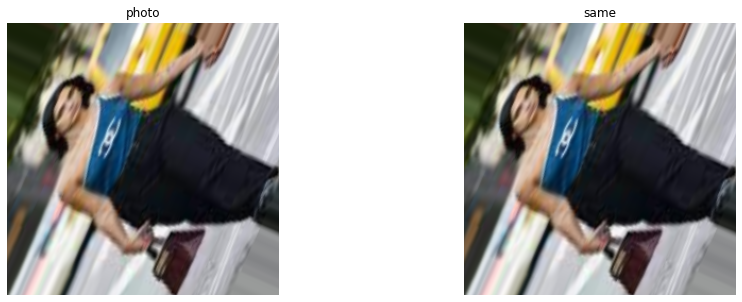

In [37]:
_ = np.random.choice(len(xs))
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(xs[_])
plt.axis('off')
plt.title('photo')
plt.subplot(122)
plt.imshow(ys[_])
plt.title('same')
plt.axis('off')

plt.show()

In [48]:
"""
Creating the model
"""
def conv_block(x, n_filt, size_conv=(5,5), n_conv=3):
    """
    Applies n_conv convolutions to the input with specified size and number of filters.
    """
    for c in range(n_conv):
        x = tf.keras.layers.Conv2D(n_filt, size_conv, padding="same", activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
    return x

def u_encoder(x, n_filt):
    """
    Applies conv_block and returnes max pooled and skip-connection.
    """
    x = conv_block(x, n_filt)
    return tf.keras.layers.MaxPool2D()(x), x

def u_decoder(pooled, skipped, n_filt):
    """
    Upsamples pooled and concats with skiped.
    """
    upsampled = tf.keras.layers.Convolution2DTranspose(n_filt, (2,2), strides=(2,2), padding='same')(pooled)
    #return conv_block(tf.keras.layers.concatenate([upsampled, skipped]), n_filt)
    return conv_block(upsampled, n_filt)
    
    
def make_unet(inp, depth=3, output_channels=3):
    skipped = []
    p = inp
    for _ in range(depth):
        p, s = u_encoder(p, 2**(1+_))
        skipped.append(s)
    p = conv_block(p, 2**(2+depth))
    p = tf.keras.layers.Lambda(lambda z:z,name='encoded')(p)
    for _ in reversed(range(depth)):
        p = u_decoder(p, skipped[_], 2**(2+_))  
    p = tf.keras.layers.Conv2D(output_channels, (1,1), activation='sigmoid')(p)
    return p

def get_generator(inp):
    """
    Takes network Input layer 
    """
    outp = make_unet(inp)
    return tf.keras.models.Model(inp, outp)

In [49]:

model = get_generator(tf.keras.layers.Input(shape=(CROP, CROP, 3)))
model.compile(optimizer='adam', loss='mse')
#model.load_weights("./checkpoints/autoencoder")

In [50]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath= f"./checkpoints/autoencoder2",
        save_weights_only=True,
        verbose = True,
        save_best_only=True),
                    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
                    tf.keras.callbacks.TerminateOnNaN()

        ]

model.fit(
    gen_auto_train,
    epochs=30,
    steps_per_epoch=50,
    validation_data=gen_auto_val,
    validation_steps=10,
    shuffle=False,
    use_multiprocessing=True,
    callbacks=callbacks,
    workers=1
)

Epoch 1/30
50/50 [==============================] - ETA: 0s - loss: 0.0845
Epoch 1: val_loss improved from inf to 0.09215, saving model to ./checkpoints/autoencoder2
50/50 [==============================] - 33s 509ms/step - loss: 0.0845 - val_loss: 0.0922 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - ETA: 0s - loss: 0.0576
Epoch 2: val_loss improved from 0.09215 to 0.09032, saving model to ./checkpoints/autoencoder2
50/50 [==============================] - 25s 508ms/step - loss: 0.0576 - val_loss: 0.0903 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - ETA: 0s - loss: 0.0441
Epoch 3: val_loss did not improve from 0.09032
50/50 [==============================] - 25s 502ms/step - loss: 0.0441 - val_loss: 0.0958 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - ETA: 0s - loss: 0.0342
Epoch 4: val_loss did not improve from 0.09032
50/50 [==============================] - 24s 481ms/step - loss: 0.0342 - val_loss: 0.1068 - lr: 0.0010
Epoch 5/

KeyboardInterrupt: 

In [121]:
xs, ys = next(gen_auto_train.as_numpy_iterator())
p = model(xs)

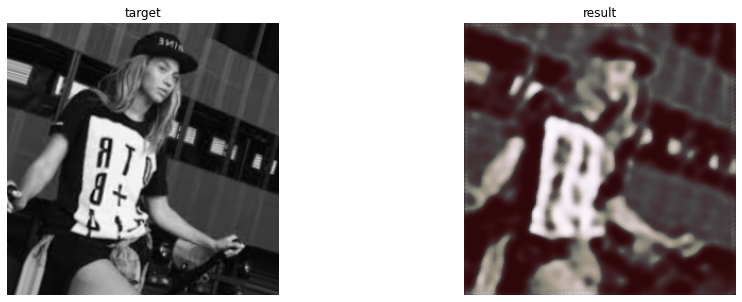

In [146]:
_ = np.random.choice(len(xs))
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(xs[_])
plt.axis('off')
plt.title('target')
plt.subplot(122)
plt.imshow(p[_])
plt.title('result')
plt.axis('off')

plt.show()

# Adversarial network

In [10]:
class AdversarialNST(tf.keras.Model):
    def __init__(self, discriminator, discriminator_real,generator, latent_dim,gen_val,margin = 1):
        super().__init__()
        self.discriminator = discriminator
        self.discriminator_real = discriminator_real
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.disc_real_loss_tracker = tf.keras.metrics.Mean(name="discriminator_real_loss")
        self.margin = margin
        self.gen_val = gen_val

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    #def compile(self, d_optimizer, g_optimizer, loss_fn):
    def compile(self, d_optimizer, d_real_optimizer,g_optimizer):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_real_optimizer = d_real_optimizer
        #self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        xs,covers = data
        photos,other_cover = xs['input_photo'],xs['input_cover']

        generated_images = self.generator(photos)
        generated_images2 = self.generator(other_cover)

        # Train the discriminator.
        with tf.GradientTape() as tape:            
            anchor = self.discriminator(generated_images)
            positive = self.discriminator(covers)
            negative = self.discriminator(generated_images2)
            
            ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
            an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
            
            d_loss = tf.maximum(an_distance - ap_distance + self.margin, 0.0)
            #d_loss += tf.random.normal(tf.shape(d_loss),0,tf.math.reduce_max(d_loss)/10)
            #d_loss = 1/(1+np.exp(-d_loss))
            
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
            
        generated_images = self.generator(photos)
        batch_size = tf.shape(generated_images)[0]
        with tf.GradientTape() as tape:   
            batch = tf.concat((generated_images,covers),axis=0)
            pred_labels = self.discriminator_real(batch)
            misleading = np.random.uniform(0,1)
            if misleading < 0.9:
                labels = tf.concat((tf.zeros(batch_size),0.9*tf.ones(batch_size)),axis=0)
            else:
                labels = tf.concat((0.9*tf.ones(batch_size),tf.zeros(batch_size)),axis=0)
            labels = tf.expand_dims(labels,axis=-1)
            d_real_loss = tf.abs(pred_labels - labels)
            
            
            
        grads = tape.gradient(d_real_loss, self.discriminator_real.trainable_weights)
        self.d_real_optimizer.apply_gradients(
            zip(grads, self.discriminator_real.trainable_weights)
        )


        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
         
            fake_images = self.generator(photos)
            fake_images2 = self.generator(other_cover)
            
            anchor = self.discriminator(fake_images)
            positive = self.discriminator(covers)
            negative = self.discriminator(fake_images2)
            
            ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
            an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
            
            g_loss = tf.maximum(ap_distance - an_distance, 0.0)
            
            real = self.discriminator_real(fake_images)
            g_loss += 1 - real
            
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.disc_real_loss_tracker.update_state(d_real_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "d_real_loss": self.disc_real_loss_tracker.result(),
        }

    def generate_images(self,num_images=16):
        #xs, ys = next(gen_batch_val.as_numpy_iterator())
        xs,covers = next(self.gen_val.as_numpy_iterator())
        photos,other_cover = xs['input_photo'],xs['input_cover']
        
        p = self.generator(photos)
        
        return [p,covers]
    
    def plot_images(
        self,epoch=None, logs=None, num_images = 5,num_rows=1, num_cols=5, figsize=(12, 5)
    ):
        generated_samples,covers = self.generate_images(num_images=num_rows * num_cols)
        
        _, ax = plt.subplots(2, 5, figsize=figsize)
        
        for i in range(num_images):
            ax[0,i].imshow((generated_samples[i]+1)/2)
            ax[0,i].axis("off")
            
            ax[1,i].imshow((covers[i]+1)/2)
            ax[1,i].axis("off")

        plt.tight_layout()
        plt.show()

In [11]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = tf.keras.layers.Flatten()(base_cnn.output)
dense1 = tf.keras.layers.Dense(512, activation="relu")(flatten)
dense1 = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(256, activation="relu")(dense1)
dense2 = tf.keras.layers.BatchNormalization()(dense2)
output = tf.keras.layers.Dense(latent_dim)(dense2)

embedding = tf.keras.models.Model(base_cnn.input, output)

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [12]:


discriminator_real = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer((CROP,CROP, 3)),
        tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Dense(1,activation='sigmoid'),
    ]
)

In [13]:

input_img_size = (CROP, CROP, 3)
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x



def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=5,
    num_residual_blocks=9,
    num_upsample_blocks=5,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size,name="img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

generator = get_resnet_generator()

/home/joel/anaconda3/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/20


2023-02-14 19:44:04.466540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8302
2023-02-14 19:44:06.087512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-14 19:44:06.917924: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f3ebd1cbae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-14 19:44:06.917942: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-02-14 19:44:06.917946: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2023-02-14 19:44:06.921926: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-14 19:44:07.01317

100/100 [==============================] - ETA: 0s - g_loss: 122.1519 - d_loss: 1.0952 - d_real_loss: 0.3488

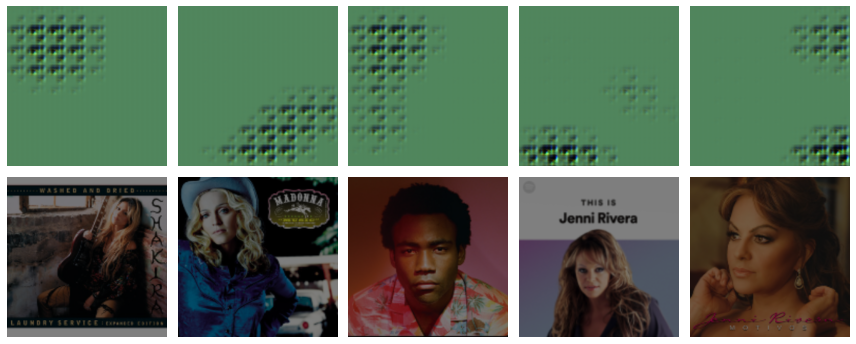

100/100 [==============================] - 182s 1s/step - g_loss: 122.2539 - d_loss: 1.1011 - d_real_loss: 0.3484
Epoch 2/20
100/100 [==============================] - ETA: 0s - g_loss: 31.5570 - d_loss: 0.2459 - d_real_loss: 0.2503

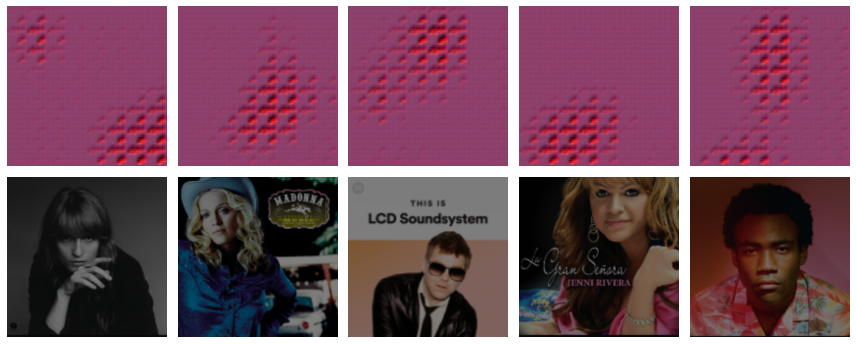

100/100 [==============================] - 145s 1s/step - g_loss: 31.4788 - d_loss: 0.2453 - d_real_loss: 0.2501
Epoch 3/20
100/100 [==============================] - ETA: 0s - g_loss: 17.7945 - d_loss: 0.0275 - d_real_loss: 0.2049

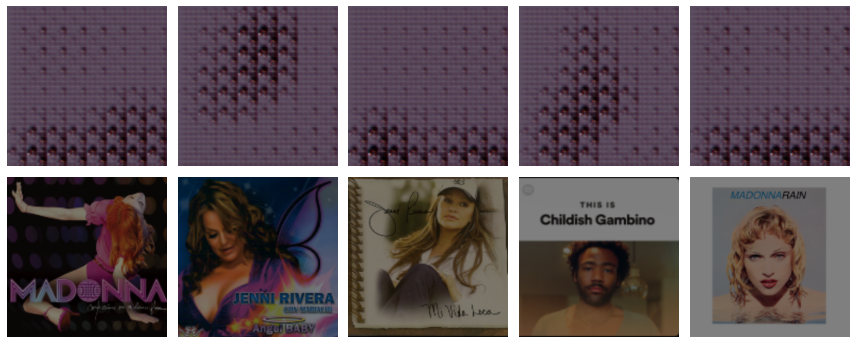

100/100 [==============================] - 145s 1s/step - g_loss: 17.7878 - d_loss: 0.0276 - d_real_loss: 0.2048
Epoch 4/20
 49/100 [=============>................] - ETA: 1:13 - g_loss: 18.5226 - d_loss: 0.1195 - d_real_loss: 0.1929

KeyboardInterrupt: 

In [14]:
adv_nst = AdversarialNST(
    discriminator=embedding,discriminator_real=discriminator_real, generator=generator, latent_dim=latent_dim,gen_val = gen_batch_val
)
adv_nst.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    d_real_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
)


callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath= f"./checkpoints/neural_style",
        save_weights_only=True,
        verbose = True,
        save_best_only=True),
                    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
                    tf.keras.callbacks.TerminateOnNaN()

        ]

adv_nst.fit(
        gen_batch_train,
        epochs=20,
        steps_per_epoch=100,
        shuffle=False,
        use_multiprocessing=True,
        workers=1,
        callbacks=[tf.keras.callbacks.LambdaCallback(on_epoch_end=adv_nst.plot_images)]
    )